DATASET LOADING 

In [4]:
import pandas as pd
df = pd.read_csv('/Users/katiamogan/Desktop/TFE.csv')
df.head()

,USER_ID,REGISTER_DATE,LINK_ID,LINK_DATE,SOURCE_ID,GMV,PROVISION,NO_TRANSACTIONS,COMMISSION
0,167920,2023-03-30 20:33:08.777,2961253,2023-06-03 08:57:03.762,rakuten-hm-de,1594.76,87.42,10,4.79
1,67648,2021-03-16 19:24:58.360,4863200,2024-11-14 09:26:14.875,private-otto,1529.13,4.61,11,3.53
2,7865,2019-04-25 23:34:42.717,2947239,2023-05-30 06:26:26.293,impact-asos-de,246.95,19.76,4,6.06
3,67648,2021-03-16 19:24:58.360,4706074,2024-10-09 13:51:02.681,private-otto,578.35,9.38,5,4.92
4,67758,2021-03-17 17:13:26.495,5027741,2024-12-19 14:44:02.152,rakuten-hm-de,171.53,10.70,4,1.90


SETTING THE DATEFRAME 

In [5]:
#check time range of the dataset
print(f"Min Date Link: {df['LINK_DATE'].min()}")
print(f"Max Date Link: {df['LINK_DATE'].max()}")

print(f"Min Date Profile: {df['REGISTER_DATE'].min()}")
print(f"Max Date Profile: {df['REGISTER_DATE'].max()}")

Min Date Link: 2023-01-01 00:48:49.063
Max Date Link: 2025-03-31 23:38:27.961
Min Date Profile: 2017-08-11 08:24:33.818
Max Date Profile: 2025-03-31 21:04:04.531


In [6]:
df.describe()

,USER_ID,LINK_ID,GMV,PROVISION,NO_TRANSACTIONS,COMMISSION
count,907531.000000,9.075310e+05,907531.000000,907531.000000,907531.000000,907531.000000
mean,113315.037898,3.868491e+06,874.676392,41.770593,8.795668,7.505117
std,73574.595818,8.594219e+05,5167.827156,246.923896,45.643357,36.219779
min,4.000000,2.468666e+06,-1.290000,0.000000,0.000000,0.000000
25%,40847.000000,3.126844e+06,0.000000,0.000000,0.000000,0.210000
50%,123704.000000,3.805115e+06,0.000000,0.000000,0.000000,1.000000
75%,169192.000000,4.633916e+06,322.580000,16.430000,4.000000,4.120000
max,284292.000000,5.438291e+06,743117.450000,56892.090000,6349.000000,7510.380000


- there are some null values that need to be cleaned up 

In [7]:
# how many records do have a negative GMV?
num_gmv_negativos = (df['GMV'] < 0).sum()
print(f"Number of records with negative GMV: {num_gmv_negativos}")

# Eliminate records where GMV < 0
stylink_df = df[df['GMV'] >= 0]

Number of records with negative GMV: 1


LIBRARY IMPORTS

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

USER_ID LOD AGGREGATION

In [10]:
stylink_df_users = df.groupby('USER_ID').agg({
    'REGISTER_DATE': 'first',
    'GMV': 'sum',
    'PROVISION': 'sum',
    'COMMISSION': 'sum',
    'NO_TRANSACTIONS': 'sum',
    'LINK_ID': 'count',
}).rename(columns={'LINK_ID': 'LINK_COUNT'}).reset_index()

stylink_df_users.head()

,USER_ID,REGISTER_DATE,GMV,PROVISION,COMMISSION,NO_TRANSACTIONS,LINK_COUNT
0,4,2017-08-11 08:24:33.818,809.38,111.90,0.42,3,5
1,15,2017-08-13 06:41:08.755,0.00,0.00,0.35,0,11
2,34,2017-08-14 16:26:16.549,2861.18,65.61,28.13,26,82
3,43,2017-08-14 17:11:04.296,34445.36,2064.53,379.72,372,82
4,67,2017-08-15 09:18:31.708,122.85,9.23,11.99,2,9


Checking the number of unique values in the dataset

In [13]:
for i in list(stylink_df_users[['USER_ID']]):
    print(f'Unique {i}: {stylink_df_users[i].nunique()}')

Unique USER_ID: 15601


DESCRIPTIVE ANALYSIS

In [12]:
stylink_df_users.describe()

,USER_ID,GMV,PROVISION,COMMISSION,NO_TRANSACTIONS,LINK_COUNT
count,15601.000000,1.560100e+04,1.560100e+04,15601.000000,15601.000000,15601.000000
mean,161277.019614,5.088109e+04,2.429851e+03,436.582654,511.655727,58.171335
std,73357.699398,4.627572e+05,2.467871e+04,3550.537464,4573.145779,404.606429
min,4.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000
25%,114912.000000,0.000000e+00,0.000000e+00,0.480000,0.000000,2.000000
50%,171582.000000,4.540000e+01,1.760000e+00,3.240000,1.000000,8.000000
75%,201043.000000,2.263860e+03,1.019700e+02,35.370000,24.000000,29.000000
max,284292.000000,2.281434e+07,1.533669e+06,236597.130000,177876.000000,16247.000000


NULL VALUES

In [14]:
# Número de filas y columnas
print("Forma del dataset:", stylink_df_users.shape)

# Tipos de datos y valores nulos
stylink_df_users.info()

# Ver valores faltantes por columna
print("\nValores nulos por columna:")
print(stylink_df_users.isnull().sum())

Forma del dataset: (15601, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15601 entries, 0 to 15600
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   USER_ID          15601 non-null  int64  
 1   REGISTER_DATE    15601 non-null  object 
 2   GMV              15601 non-null  float64
 3   PROVISION        15601 non-null  float64
 4   COMMISSION       15601 non-null  float64
 5   NO_TRANSACTIONS  15601 non-null  int64  
 6   LINK_COUNT       15601 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 853.3+ KB

Valores nulos por columna:
USER_ID            0
REGISTER_DATE      0
GMV                0
PROVISION          0
COMMISSION         0
NO_TRANSACTIONS    0
LINK_COUNT         0
dtype: int64


DUPLICATES

In [15]:
no_of_dups = stylink_df_users.duplicated().sum()
print("Número de filas que contienen duplicados:", no_of_dups)

Número de filas que contienen duplicados: 0


In [16]:
# Aggregate GMV and Provision by User_ID
gmv_by_user_id = df.groupby('USER_ID')['GMV'].sum()
prov_by_user_id = df.groupby('USER_ID')['PROVISION'].sum()

# Order values from bigger to smaller
gmv_by_userid_sorted = gmv_by_user_id.sort_values(ascending=False)
prov_by_userid_sorted = prov_by_user_id.sort_values(ascending=False)

# Show results
print(gmv_by_userid_sorted)
print(prov_by_userid_sorted)

USER_ID
16712     2.281434e+07
172963    1.881916e+07
1646      1.765719e+07
8045      1.734053e+07
146942    1.459088e+07
              ...     
180312    0.000000e+00
89774     0.000000e+00
180154    0.000000e+00
180146    0.000000e+00
284292    0.000000e+00
Name: GMV, Length: 15601, dtype: float64
USER_ID
172963    1.533669e+06
1646      1.253319e+06
146942    8.861062e+05
72956     7.016998e+05
171532    6.750537e+05
              ...     
177350    0.000000e+00
177345    0.000000e+00
177344    0.000000e+00
177342    0.000000e+00
284292    0.000000e+00
Name: PROVISION, Length: 15601, dtype: float64


CORRELATION MATRIX

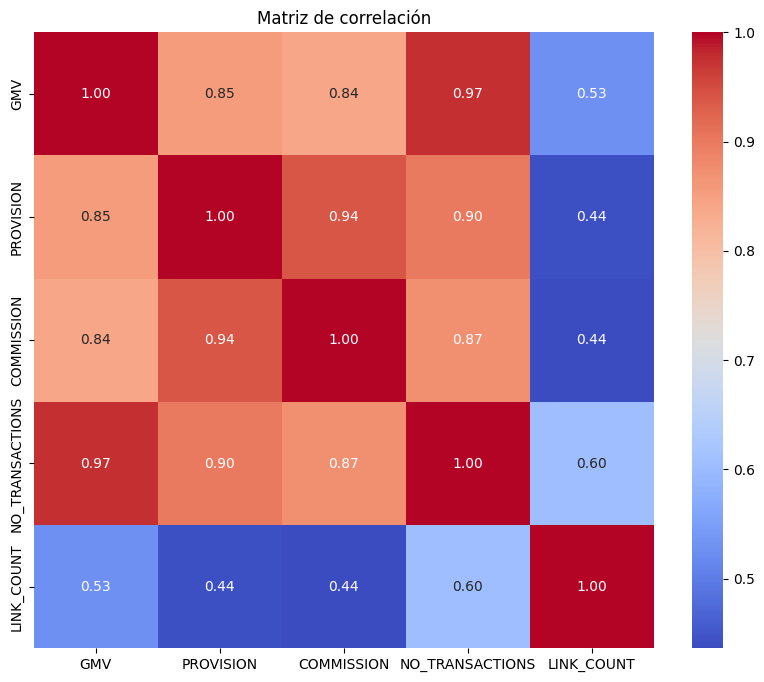

In [17]:
# Eliminate non numeric columns 
stylink_df_users_corr = stylink_df_users.drop(columns=['USER_ID'], errors='ignore')

correlation = stylink_df_users_corr.corr(numeric_only=True)

# Visualize matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

VARIABLE DISTRIBUTION (HISTOGRAMS)

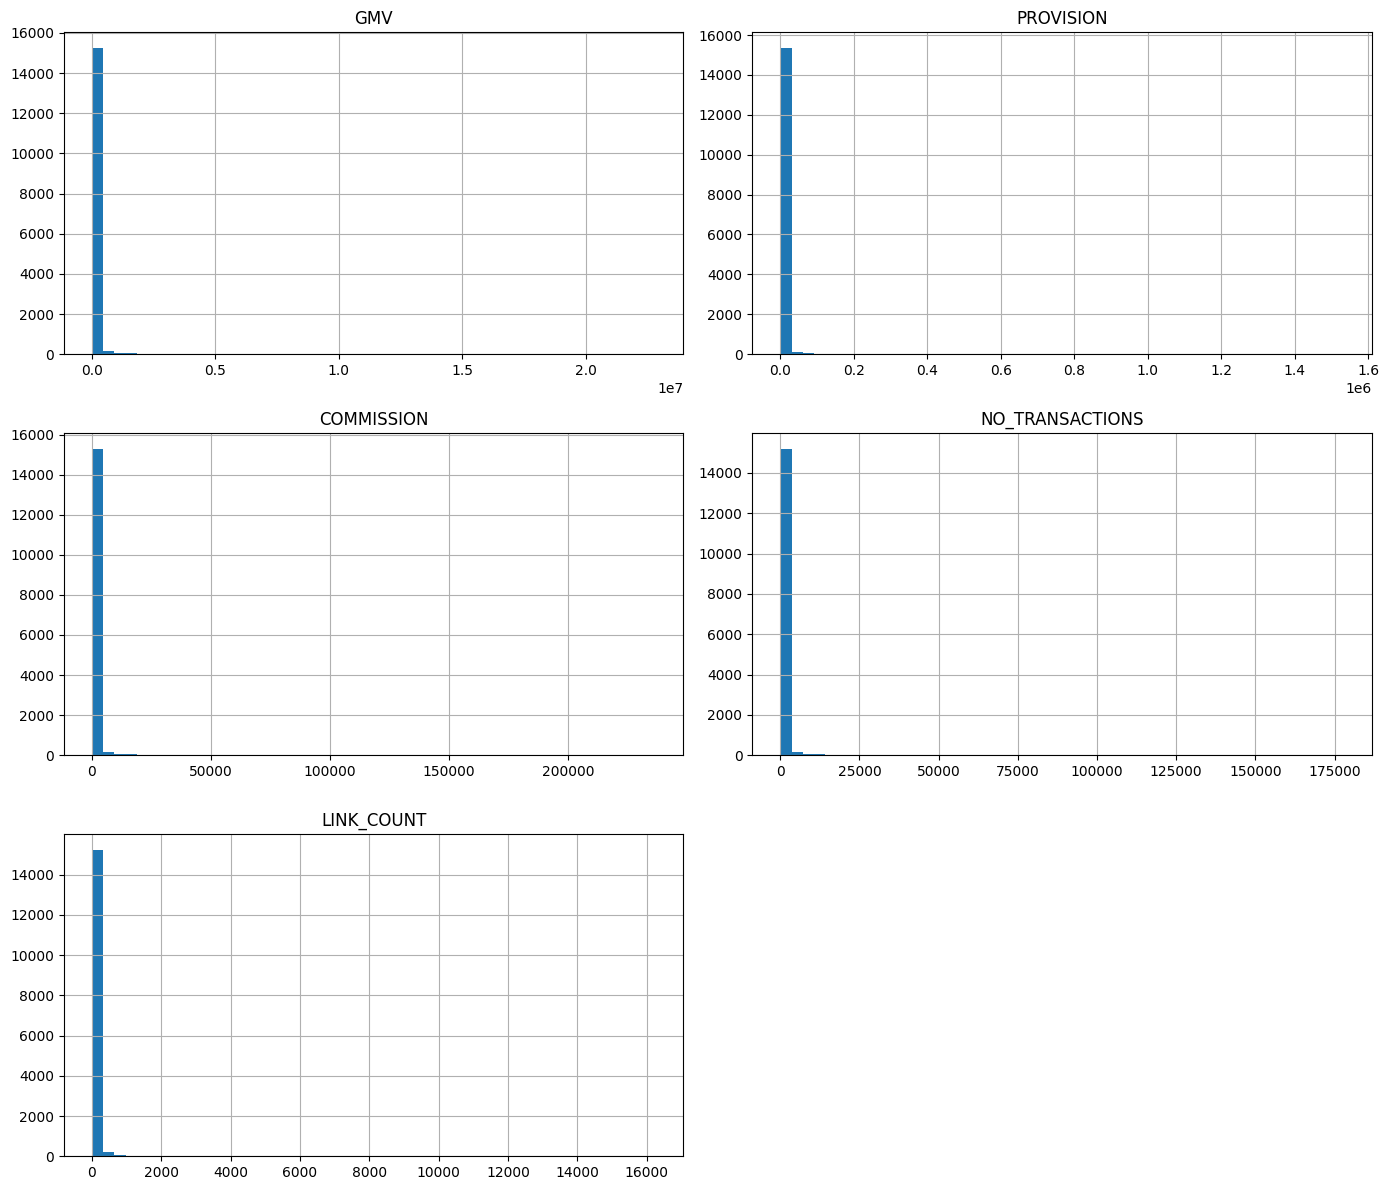

In [18]:
stylink_df_users_no_id = stylink_df_users.drop(columns=['USER_ID'], errors='ignore')

stylink_df_users_no_id.hist(figsize=(14, 12), bins=50)  
plt.tight_layout()
plt.show()

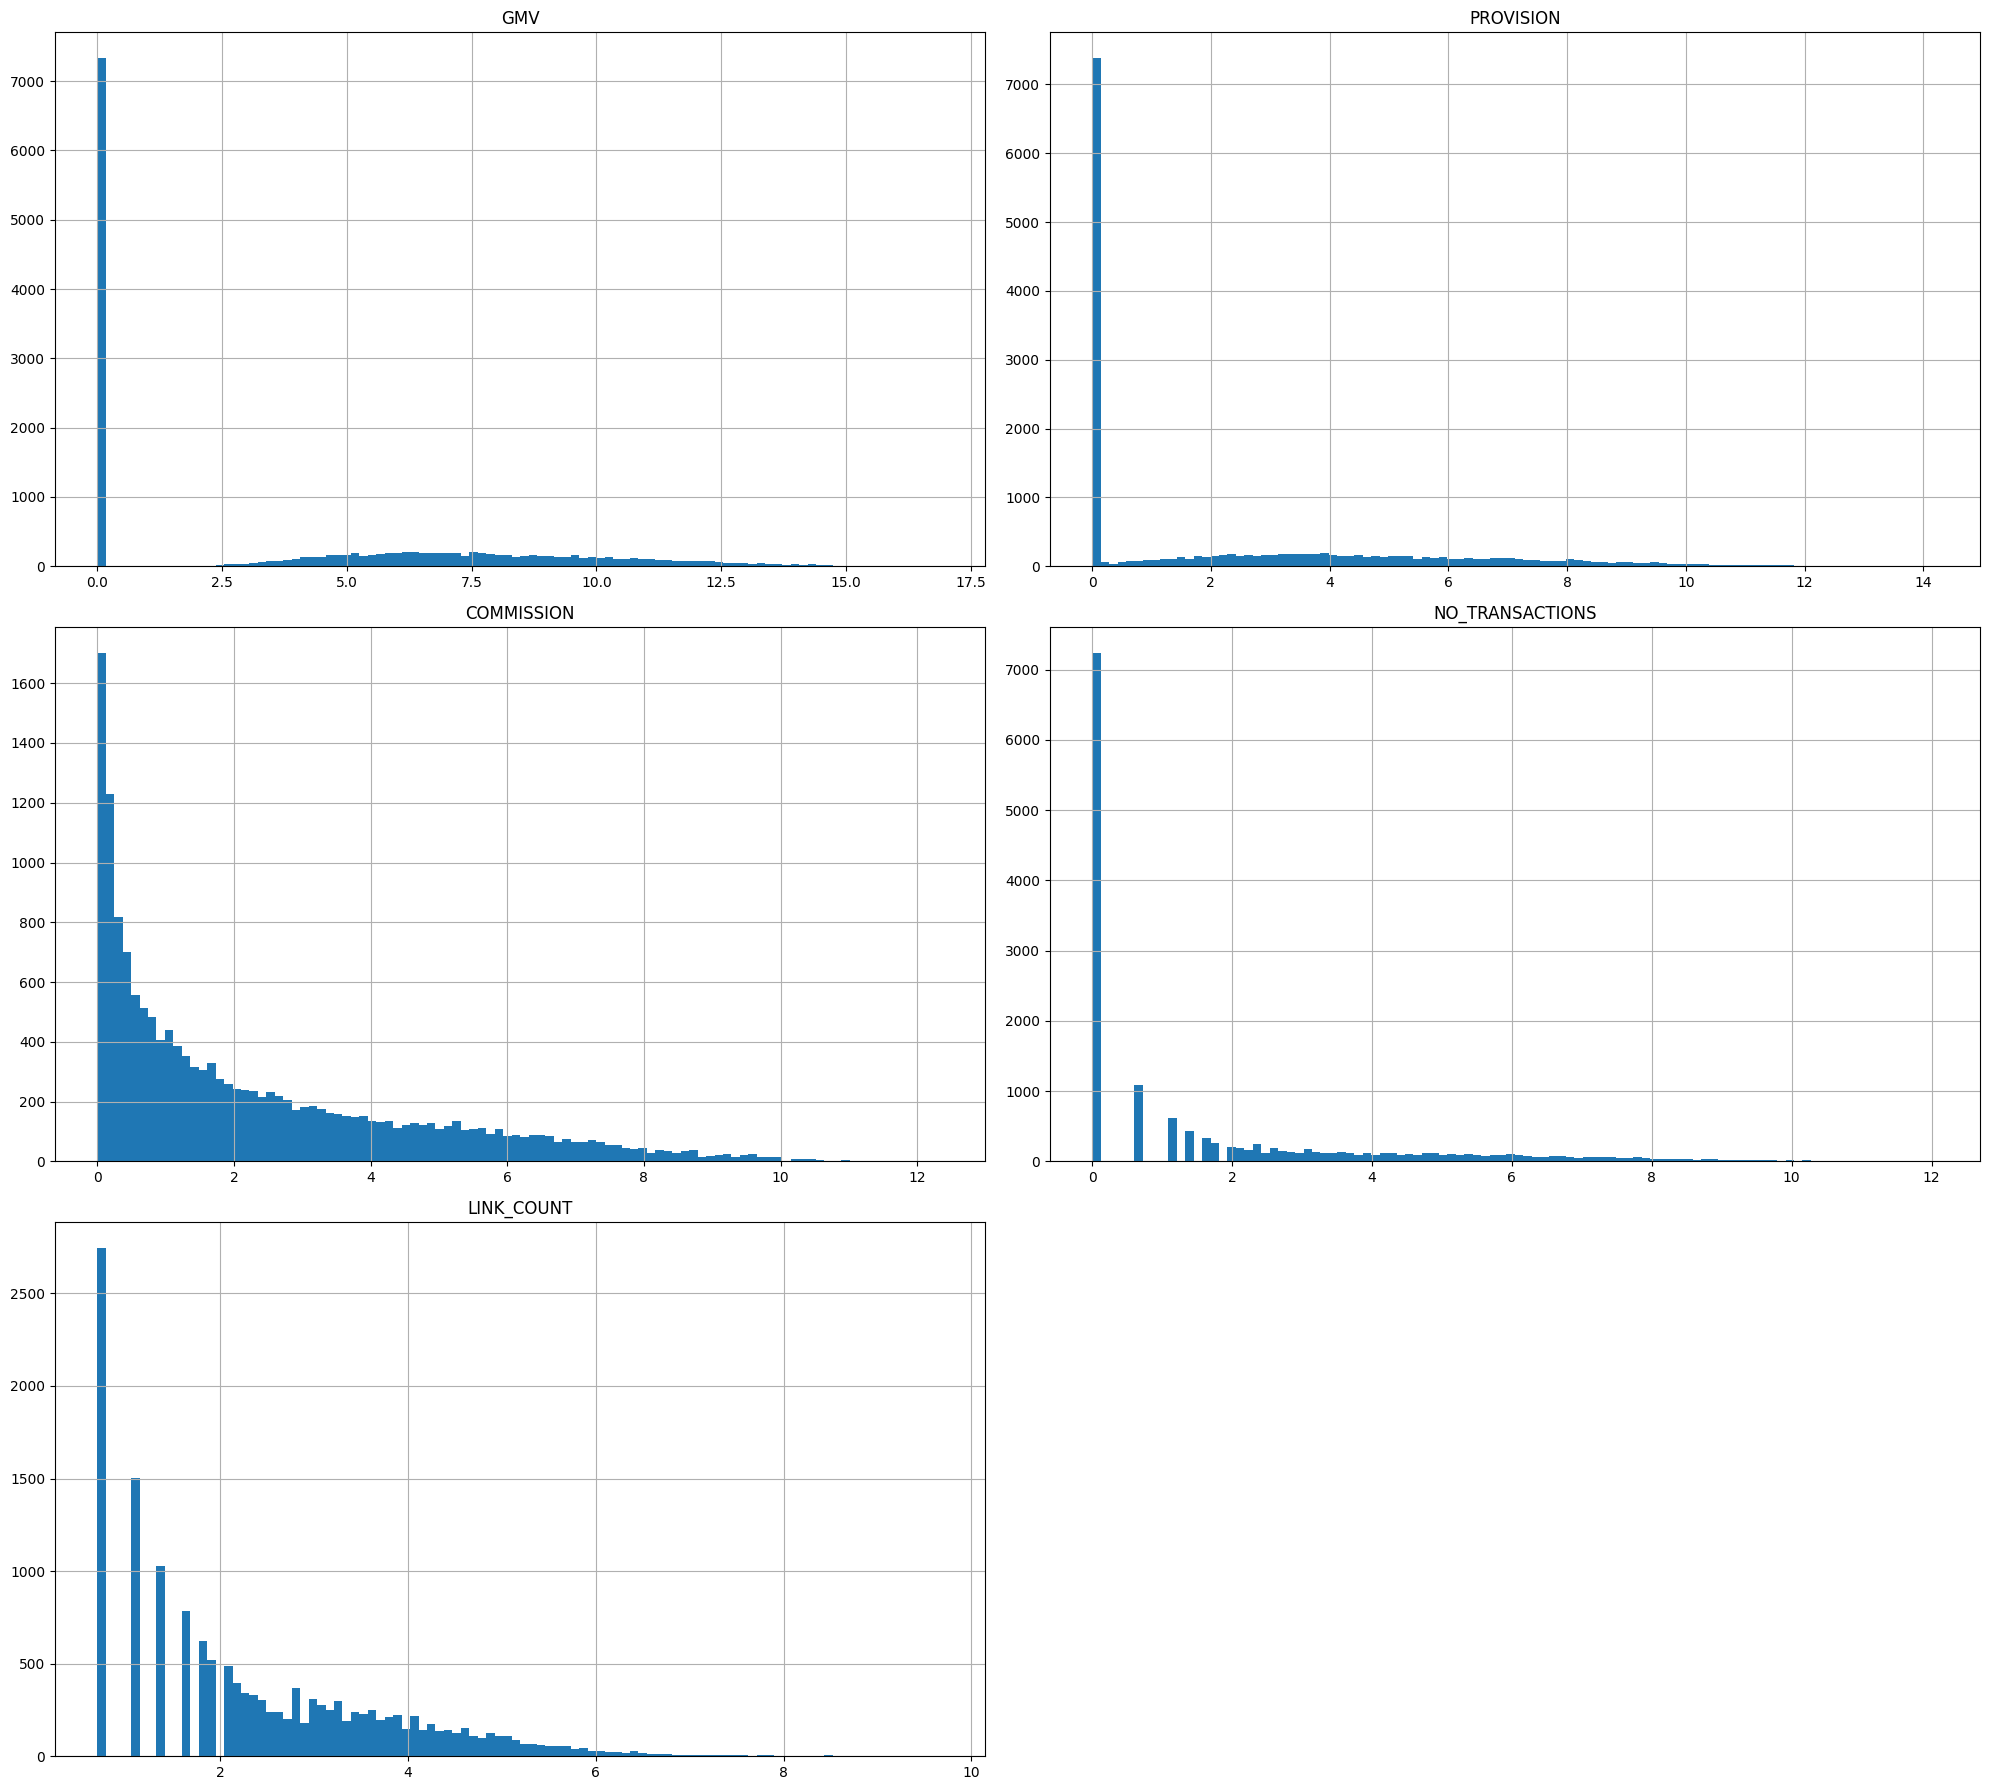

In [20]:
# Logarithmic transformation to reduce data asymmetry
stylink_df_users_no_id = stylink_df_users.drop(columns=['USER_ID'], errors='ignore')
stylink_df_users_log = stylink_df_users_no_id.copy()
stylink_df_users_log[stylink_df_users_no_id.select_dtypes(include=np.number).columns] = np.log1p(stylink_df_users_no_id.select_dtypes(include=np.number))

# Visualize histograms
stylink_df_users_log.hist(figsize=(20, 18), bins=100)
plt.tight_layout()
plt.show()

OUTLIERS (BOXPLOTS)

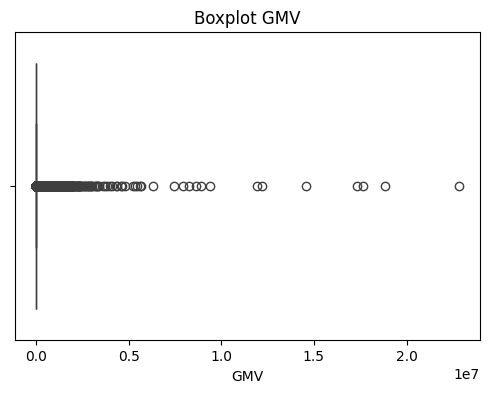

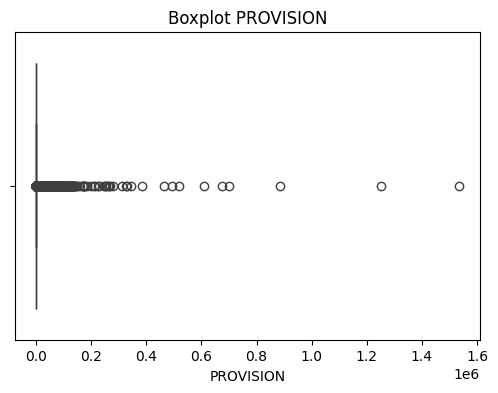

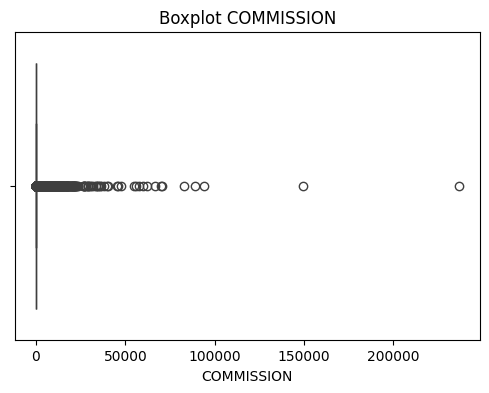

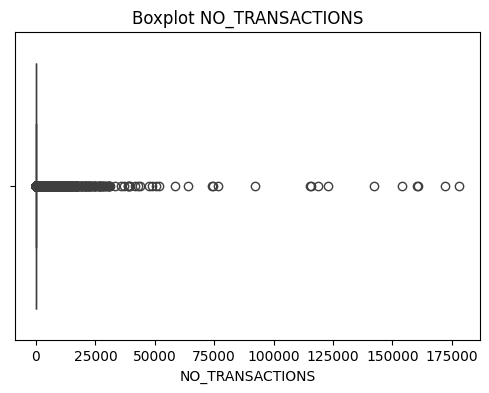

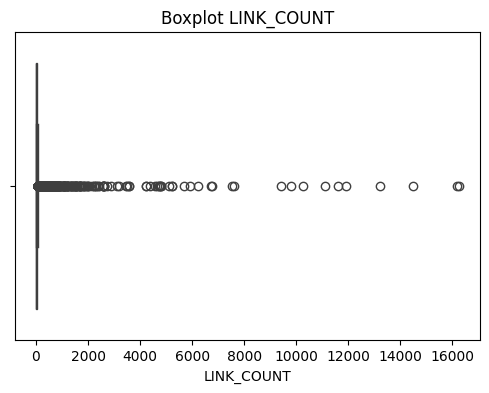

In [21]:
for col in stylink_df_users_no_id.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=stylink_df_users_no_id[col])
    plt.title(f"Boxplot {col}")
    plt.show()

DATA PREPARATION: CLEANING
- Eliminate negative GMV, user_id where transaction count = 0, feature engineering

how many users have generated provision with their links?

In [23]:
#active users, i.e. all users with transactions
df_stylink_active = stylink_df_users.query("PROVISION != 0")
df_stylink_active.USER_ID.nunique()

8296

how many users dont have links with transactions?

In [24]:
# filter user_id with NO_TRANSACTIONS = 0
usuarios_sin_transacciones = stylink_df_users[stylink_df_users['PROVISION'] == 0]

# show ID and total count
user_ids_sin_transacciones = usuarios_sin_transacciones['USER_ID'].tolist()
total_sin_transacciones = len(user_ids_sin_transacciones)

print("USER_IDs with PROVISION = 0:", user_ids_sin_transacciones)
print("Total count of users without transactions:", total_sin_transacciones)

stylink_df_users = stylink_df_users[~stylink_df_users['USER_ID'].isin(user_ids_sin_transacciones)]


USER_IDs with PROVISION = 0: []
Total count of users without transactions: 0


feature engineering: Factor, First link date, Last link date, Length, Recency, Activity, Unique_days, Links_w_trans, Perc_links_w_trans, Frequency, Avg_links_per_month, Atv, churn, Min/max Windows, Diversity


FACTOR

In [25]:
# Eliminate null values in commission so that division can be performed
df['FACTOR'] = df.apply(
    lambda row: row['PROVISION'] / row['COMMISSION'] if row['COMMISSION'] != 0 else 0,
    axis=1
)

# set 'LINK_DATE' to datetime
df['LINK_DATE'] = pd.to_datetime(df['LINK_DATE'])

# Avg Factor per user id 
factor_media_por_usuario = df.groupby('USER_ID')['FACTOR'].mean().reset_index()

# Show results
print(factor_media_por_usuario.head())

   USER_ID      FACTOR
0        4  275.700000
1       15    0.000000
2       34    2.580144
3       43    5.932099
4       67    0.126925


FIRST LINK DATE, LAST LINK DATE, LENGTH 

In [26]:

df['LINK_DATE'] = pd.to_datetime(df['LINK_DATE'])

# FIRST_LINK_DATE y LAST_LINK_DATE 
df['FIRST_LINK_DATE'] = df.groupby('USER_ID')['LINK_DATE'].transform('min').dt.date
df['LAST_LINK_DATE'] = df.groupby('USER_ID')['LINK_DATE'].transform('max').dt.date

# LENGTH_DAYS 
df['LENGTH'] = (
    pd.to_datetime(df['LAST_LINK_DATE']) - pd.to_datetime(df['FIRST_LINK_DATE'])
).dt.days

print(df[['USER_ID', 'FIRST_LINK_DATE', 'LAST_LINK_DATE', 'LENGTH']].head())


   USER_ID FIRST_LINK_DATE LAST_LINK_DATE  LENGTH
0   167920      2023-05-16     2025-03-26     680
1    67648      2023-01-11     2025-03-20     799
2     7865      2023-02-25     2025-03-31     765
3    67648      2023-01-11     2025-03-20     799
4    67758      2023-01-01     2025-03-31     820


ACTIVITY

In [27]:
# 'ACTIVITY': number of unique days with links per USER_ID
activity_por_usuario = df.groupby('USER_ID')['LINK_DATE'].nunique().reset_index(name='ACTIVITY')

# Show results
print(activity_por_usuario.head())


   USER_ID  ACTIVITY
0        4         5
1       15        11
2       34        82
3       43        82
4       67         9


RECENCY

In [28]:
# RECENCY
fecha_extraccion = pd.to_datetime("2025-04-01")
df['RECENCY'] = (
    fecha_extraccion - pd.to_datetime(df['LAST_LINK_DATE'])
).dt.days

print(df[['USER_ID', 'RECENCY']].head())


   USER_ID  RECENCY
0   167920        6
1    67648       12
2     7865        1
3    67648       12
4    67758        1


LINKS WITH TRANSACCIONES AND FREQUENCY

In [29]:
# STEP 1: total count of LINK_IDs per USER_ID
df['FREQUENCY'] = df.groupby('USER_ID')['LINK_ID'].transform('count')

# STEP 2: create column LINKS_CON_TRANSACCIONES only for user ids with transactions > 0
mask_transacciones = df['NO_TRANSACTIONS'] > 0
df['LINKS_W_TRANSACTIONS'] = df[mask_transacciones].groupby('USER_ID')['LINK_ID'].transform('count')

# Replace NaN with 0 (for users without transactions)
df['LINKS_W_TRANSACTIONS'] = df['LINKS_W_TRANSACTIONS'].fillna(0)

# STEP 3: calculate percentage
df['PERC_LINKS_W_TRANSACTIONS'] = ((df['LINKS_W_TRANSACTIONS'] / df['FREQUENCY']) * 100).round(2)

# Show results
print(df[['USER_ID', 'FREQUENCY', 'LINKS_W_TRANSACTIONS', 'PERC_LINKS_W_TRANSACTIONS']].head())

   USER_ID  FREQUENCY  LINKS_W_TRANSACTIONS  PERC_LINKS_W_TRANSACTIONS
0   167920        258                 171.0                      66.28
1    67648       1978                 930.0                      47.02
2     7865      11613                8725.0                      75.13
3    67648       1978                 930.0                      47.02
4    67758      16191               13057.0                      80.64


DIVERSITY

In [30]:
# Calculate number of unique SOURCE_ID per USER_ID 
df['DIVERSITY'] = df.groupby('USER_ID')['SOURCE_ID'].transform('nunique')

# Show results
print(df[['USER_ID', 'DIVERSITY']].drop_duplicates().head())


   USER_ID  DIVERSITY
0   167920         16
1    67648         62
2     7865         45
4    67758         36
5    72956         33


AVERAGE LINKS PER MONTH

In [31]:
df['LINK_DATE'] = pd.to_datetime(df['LINK_DATE'])

# Create year/month column
df['LINK_YEAR_MONTH'] = df['LINK_DATE'].dt.to_period('M')

# Count LINKS per USER_ID and month
df['LINKS_PER_MONTH'] = df.groupby(['USER_ID', 'LINK_YEAR_MONTH'])['LINK_ID'].transform('count')

# Calculate avg links per month per user id
df['AVG_LINKS_PER_MONTH'] = df.groupby('USER_ID')['LINKS_PER_MONTH'].transform('mean').round(2)

# Show results per user id
print(df[['USER_ID', 'AVG_LINKS_PER_MONTH']].drop_duplicates().head())

   USER_ID  AVG_LINKS_PER_MONTH
0   167920                27.22
1    67648               228.56
2     7865               560.31
4    67758               655.74
5    72956               442.41


ATV

In [32]:
# Step 1: Calculate TOTAL_GMV y TOTAL_TRANSACTIONS per USER_ID
df['TOTAL_GMV'] = df.groupby('USER_ID')['GMV'].transform('sum')
df['TOTAL_TRANSACTIONS'] = df.groupby('USER_ID')['NO_TRANSACTIONS'].transform('sum')

# Step 2: Calculate ATV
# avoid division by 0 if count total transactions = 0 
df['ATV'] = (df['TOTAL_GMV'] / df['TOTAL_TRANSACTIONS']).replace([np.inf, -np.inf], np.nan).round(2)

# Show results per user id 
print(df[['USER_ID', 'ATV']].drop_duplicates().head())


   USER_ID     ATV
0   167920  109.01
1    67648  128.87
2     7865   75.19
4    67758   75.03
5    72956   79.33


CREATE FINAL DATASET

In [33]:
df['LINK_DATE'] = pd.to_datetime(df['LINK_DATE'])
df['REGISTER_DATE'] = pd.to_datetime(df['REGISTER_DATE'])

# Set extraction date
fecha_extraccion = pd.to_datetime("2025-04-01")

# Calculate 'LINK_YEAR_MONTH' 
df['LINK_YEAR_MONTH'] = df['LINK_DATE'].dt.to_period('M')

# Calculate Factor
df['FACTOR'] = df['PROVISION'] / df['COMMISSION']
df['FACTOR'] = df['FACTOR'].fillna(0)

# Calculate FIRST_LINK_DATE, LAST_LINK_DATE, LENGTH
first_last = df.groupby('USER_ID')['LINK_DATE'].agg(['min', 'max']).reset_index()
first_last.columns = ['USER_ID', 'FIRST_LINK_DATE', 'LAST_LINK_DATE']
first_last['LENGTH'] = (first_last['LAST_LINK_DATE'] - first_last['FIRST_LINK_DATE']).dt.days

# Calculate ACTIVITY, UNIQUE_DAYS
activity = df.groupby('USER_ID')['LINK_DATE'].nunique().reset_index(name='ACTIVITY')

# Calculate RECENCY
first_last['RECENCY'] = (fecha_extraccion - first_last['LAST_LINK_DATE']).dt.days

# Calculate LINKS_W_TRANSACTIONS, PERC_LINKS_W_TRANSACTIONS
links_with_transactions = df[df['NO_TRANSACTIONS'] > 0].groupby('USER_ID')['LINK_ID'].count().reset_index(name='LINKS_W_TRANSACTIONS')
frequency = df.groupby('USER_ID')['LINK_ID'].count().reset_index(name='FREQUENCY')
links_transactions = pd.merge(frequency, links_with_transactions, on='USER_ID', how='left')
links_transactions['LINKS_W_TRANSACTIONS'] = links_transactions['LINKS_W_TRANSACTIONS'].fillna(0)
links_transactions['PERC_LINKS_W_TRANSACTIONS'] = ((links_transactions['LINKS_W_TRANSACTIONS'] / links_transactions['FREQUENCY']) * 100).round(2)

# Calculate DIVERSITY
diversity = df.groupby('USER_ID')['SOURCE_ID'].nunique().reset_index(name='DIVERSITY')

# Calculate AVG_LINKS_PER_MONTH
monthly_counts = df.groupby(['USER_ID', 'LINK_YEAR_MONTH'])['LINK_ID'].count().reset_index(name='LINKS_PER_MONTH')
avg_links_per_month = monthly_counts.groupby('USER_ID')['LINKS_PER_MONTH'].mean().reset_index(name='AVG_LINKS_PER_MONTH').round(2)

# Calculate TOTAL_GMV, TOTAL_TRANSACTIONS
total_gmv = df.groupby('USER_ID')['GMV'].sum().reset_index(name='TOTAL_GMV')
total_transactions = df.groupby('USER_ID')['NO_TRANSACTIONS'].sum().reset_index(name='TOTAL_TRANSACTIONS')

# Calculate ATV
atv = pd.merge(total_gmv, total_transactions, on='USER_ID', how='left')
atv['ATV'] = (atv['TOTAL_GMV'] / atv['TOTAL_TRANSACTIONS']).round(2)

# Join all new features into one dataset
stylink_df = df[['USER_ID', 'REGISTER_DATE']].drop_duplicates()
stylink_df = stylink_df.merge(factor_media_por_usuario, on='USER_ID', how='left')
stylink_df = stylink_df.merge(first_last, on='USER_ID', how='left')
stylink_df = stylink_df.merge(activity[['USER_ID', 'ACTIVITY']], on='USER_ID', how='left')
stylink_df = stylink_df.merge(links_transactions[['USER_ID', 'LINKS_W_TRANSACTIONS', 'PERC_LINKS_W_TRANSACTIONS']], on='USER_ID', how='left')
stylink_df = stylink_df.merge(diversity, on='USER_ID', how='left')
stylink_df = stylink_df.merge(avg_links_per_month, on='USER_ID', how='left')
stylink_df = stylink_df.merge(atv[['USER_ID', 'ATV']], on='USER_ID', how='left')



In [35]:
# Identify duplicates (excluding 'USER_ID')
columnas_duplicadas = [col for col in stylink_df.columns if col in stylink_df_users.columns and col != 'USER_ID']
# Eliminate duplicates from stylink_df_users
stylink_df_filtrado = stylink_df.drop(columns=columnas_duplicadas)
# Merge DataFrames with left join
stylink_df_users = stylink_df_users.merge(stylink_df_filtrado, on='USER_ID', how='left')
# Show dataframe
print(stylink_df_users)

      USER_ID            REGISTER_DATE       GMV  PROVISION  COMMISSION  \
0           4  2017-08-11 08:24:33.818    809.38     111.90        0.42   
1          34  2017-08-14 16:26:16.549   2861.18      65.61       28.13   
2          43  2017-08-14 17:11:04.296  34445.36    2064.53      379.72   
3          67  2017-08-15 09:18:31.708    122.85       9.23       11.99   
4          73  2017-08-15 14:16:48.400  90048.65    3257.23      894.56   
...       ...                      ...       ...        ...         ...   
8291   283826  2025-03-28 14:58:28.160    352.92      49.41        4.19   
8292   283877  2025-03-28 20:41:23.519     37.86       3.03        8.86   
8293   283953  2025-03-29 13:00:15.177     57.48       4.60       27.56   
8294   283993  2025-03-29 21:10:14.557     75.59       4.54        1.36   
8295   284081  2025-03-30 18:18:20.077    219.92      14.26       20.80   

      NO_TRANSACTIONS  LINK_COUNT      FACTOR         FIRST_LINK_DATE  \
0                   3     

Add column for churn calculation

In [36]:
# Define recency threshold to calculate Churn
umbral_churn = 90  # días

# Add column
stylink_df_users['CHURN'] = (stylink_df_users['RECENCY'] >= umbral_churn).astype(int)
print(stylink_df_users)


      USER_ID            REGISTER_DATE       GMV  PROVISION  COMMISSION  \
0           4  2017-08-11 08:24:33.818    809.38     111.90        0.42   
1          34  2017-08-14 16:26:16.549   2861.18      65.61       28.13   
2          43  2017-08-14 17:11:04.296  34445.36    2064.53      379.72   
3          67  2017-08-15 09:18:31.708    122.85       9.23       11.99   
4          73  2017-08-15 14:16:48.400  90048.65    3257.23      894.56   
...       ...                      ...       ...        ...         ...   
8291   283826  2025-03-28 14:58:28.160    352.92      49.41        4.19   
8292   283877  2025-03-28 20:41:23.519     37.86       3.03        8.86   
8293   283953  2025-03-29 13:00:15.177     57.48       4.60       27.56   
8294   283993  2025-03-29 21:10:14.557     75.59       4.54        1.36   
8295   284081  2025-03-30 18:18:20.077    219.92      14.26       20.80   

      NO_TRANSACTIONS  LINK_COUNT      FACTOR         FIRST_LINK_DATE  \
0                   3     

ONE DAY USERS

In [37]:
ONE_DAY = stylink_df_users.query("ACTIVITY == 1")
ONE_DAY.USER_ID.nunique()

322

Absolute Values:
CHURN
0    4351
1    3945
Name: count, dtype: int64

Relative Values:
CHURN
0    52.446962
1    47.553038
Name: proportion, dtype: float64


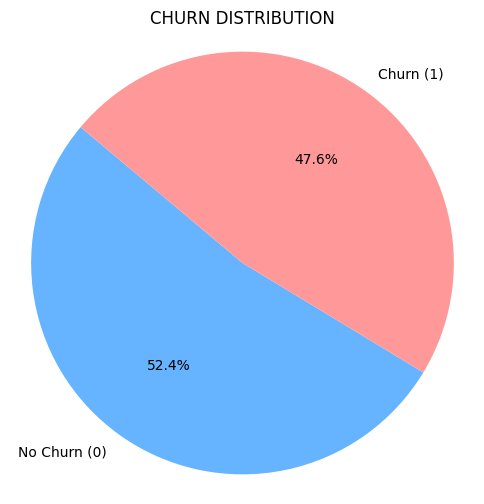

In [44]:
# Absolute values churn
churn_counts_abs = stylink_df_users['CHURN'].value_counts()

# Relative values churn 
churn_counts_rel = stylink_df_users['CHURN'].value_counts(normalize=True) * 100

# Show values
print("Absolute Values:")
print(churn_counts_abs)
print("\nRelative Values:")
print(churn_counts_rel)

# Pie Chart
labels = ['No Churn (0)', 'Churn (1)']
colors = ['#66b3ff', '#ff9999']
plt.figure(figsize=(6, 6))
plt.pie(churn_counts_abs, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('CHURN DISTRIBUTION')
plt.axis('equal')  # Circulo perfecto
plt.show()

NULL VALUES AND DUPLICATES IN THE NEW DATAFRAME

In [45]:
print("\nValores nulos por columna:")
print(stylink_df_users.isnull().sum())


Valores nulos por columna:
USER_ID                      0
REGISTER_DATE                0
GMV                          0
PROVISION                    0
COMMISSION                   0
NO_TRANSACTIONS              0
LINK_COUNT                   0
FACTOR                       0
FIRST_LINK_DATE              0
LAST_LINK_DATE               0
LENGTH                       0
RECENCY                      0
ACTIVITY                     0
LINKS_W_TRANSACTIONS         0
PERC_LINKS_W_TRANSACTIONS    0
DIVERSITY                    0
AVG_LINKS_PER_MONTH          0
ATV                          0
CHURN                        0
dtype: int64


In [47]:
no_of_dups = stylink_df_users.duplicated().sum()
print("Number of rows containing duplicates:", no_of_dups)

Number of rows containing duplicates: 0


In [48]:
stylink_df_users.head()

,USER_ID,REGISTER_DATE,GMV,PROVISION,COMMISSION,NO_TRANSACTIONS,LINK_COUNT,FACTOR,FIRST_LINK_DATE,LAST_LINK_DATE,LENGTH,RECENCY,ACTIVITY,LINKS_W_TRANSACTIONS,PERC_LINKS_W_TRANSACTIONS,DIVERSITY,AVG_LINKS_PER_MONTH,ATV,CHURN
0,4,2017-08-11 08:24:33.818,809.38,111.90,0.42,3,5,275.700000,2023-03-14 13:27:47.388,2025-01-09 20:17:56.838,667,81,5,3.0,60.00,4,1.67,269.79,0
1,34,2017-08-14 16:26:16.549,2861.18,65.61,28.13,26,82,2.580144,2023-10-18 07:56:22.892,2024-03-22 06:10:19.871,155,374,82,10.0,12.20,8,16.40,110.05,1
2,43,2017-08-14 17:11:04.296,34445.36,2064.53,379.72,372,82,5.932099,2023-11-30 07:10:01.985,2025-03-09 11:35:38.232,465,22,82,56.0,68.29,15,5.86,92.60,0
3,67,2017-08-15 09:18:31.708,122.85,9.23,11.99,2,9,0.126925,2023-05-30 08:00:46.010,2024-06-29 12:09:22.990,396,275,9,1.0,11.11,3,2.25,61.42,1
4,73,2017-08-15 14:16:48.400,90048.65,3257.23,894.56,884,358,4.048598,2023-01-09 20:58:13.957,2025-03-28 22:40:29.845,809,3,358,157.0,43.85,39,14.32,101.86,0


CORRELATION MATRIX IN NEW DATASET

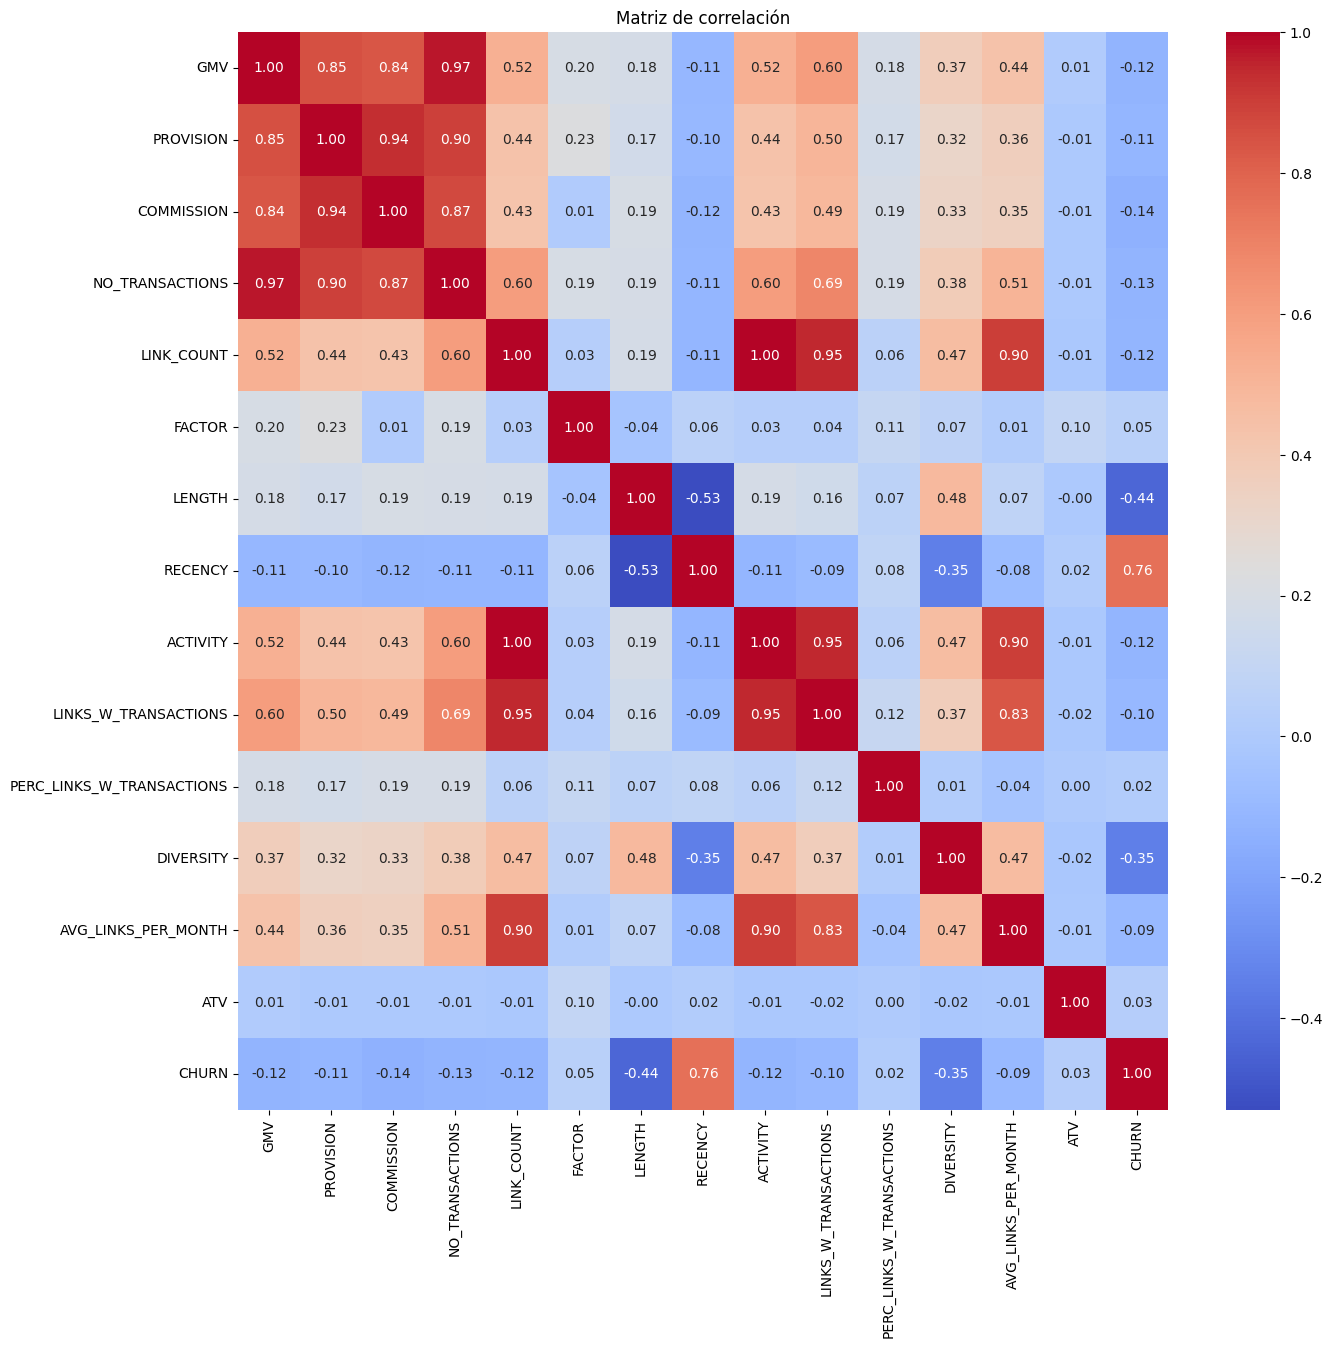

In [49]:
stylink_df_users_corr = stylink_df_users.drop(columns=['USER_ID'], errors='ignore')

correlation_users = stylink_df_users_corr.corr(numeric_only=True)

plt.figure(figsize=(15, 14))
sns.heatmap(correlation_users, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

OUTLIERS IN THE NEW DATAFRAME

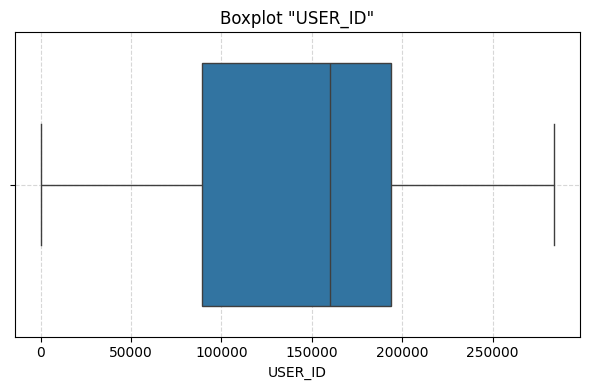

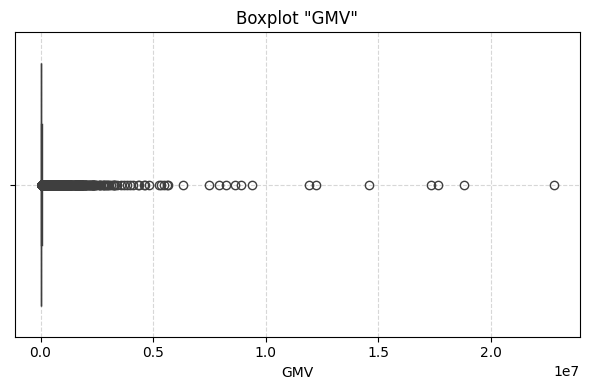

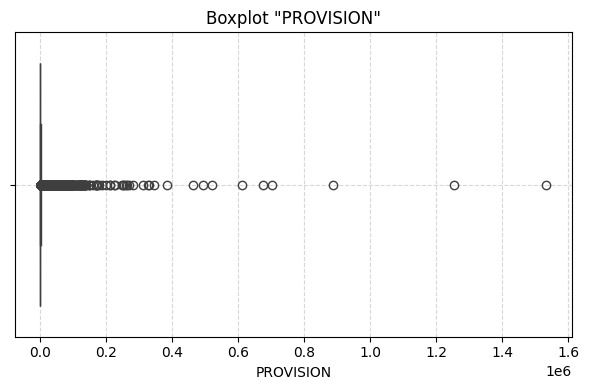

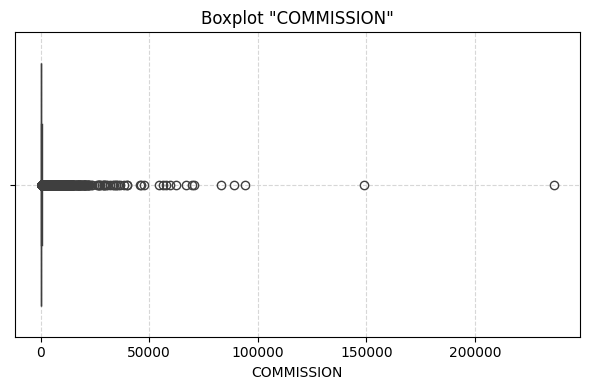

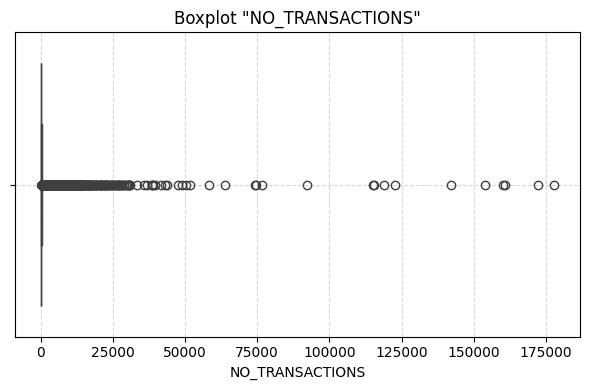

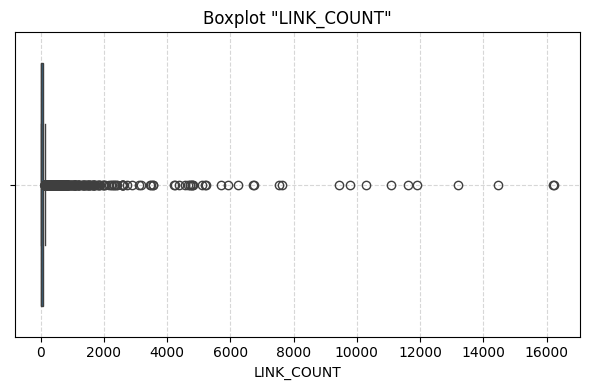

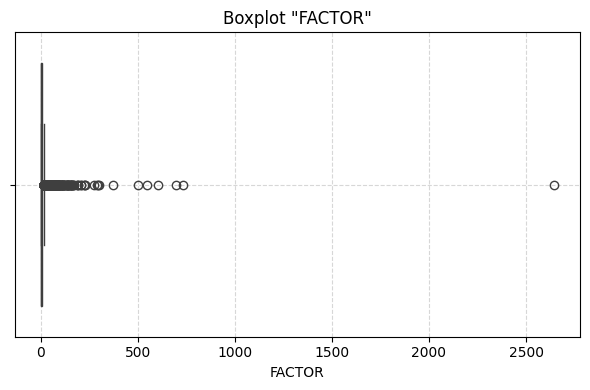

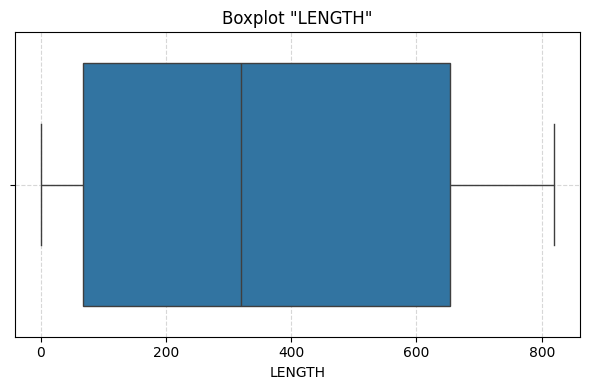

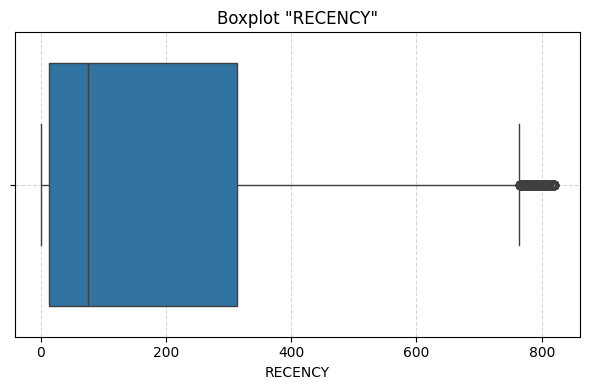

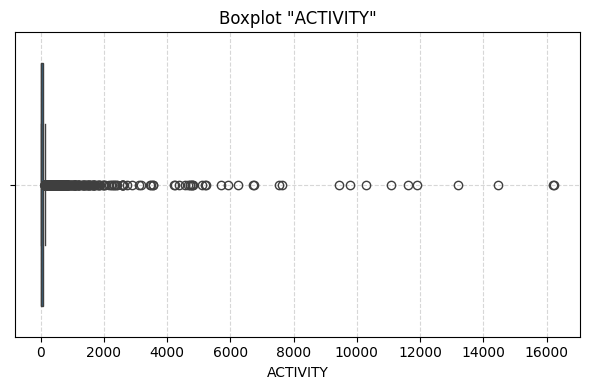

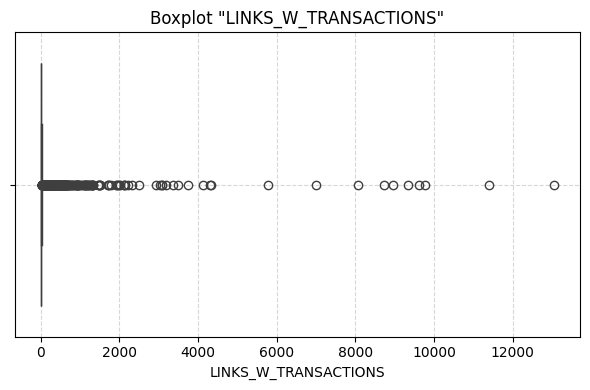

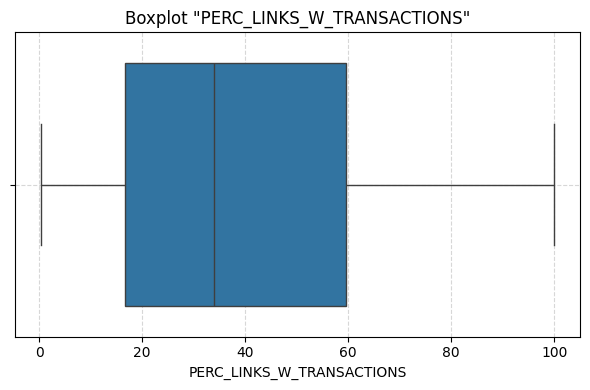

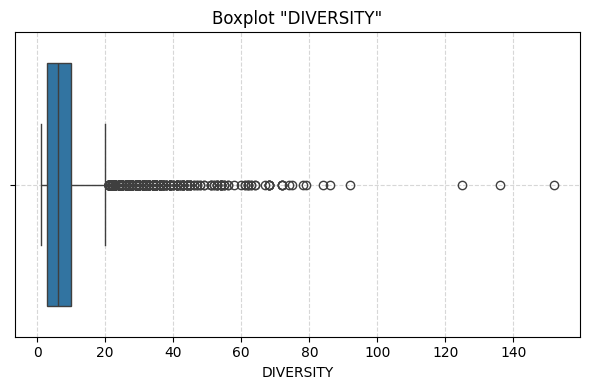

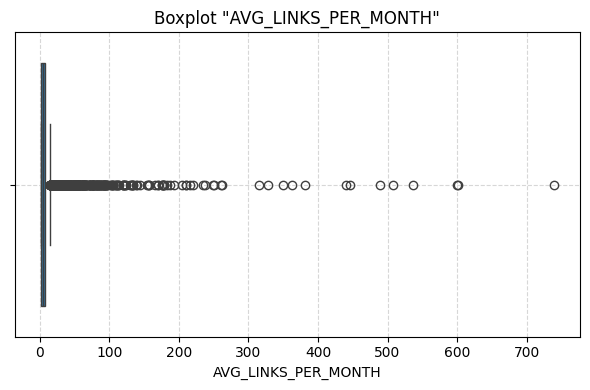

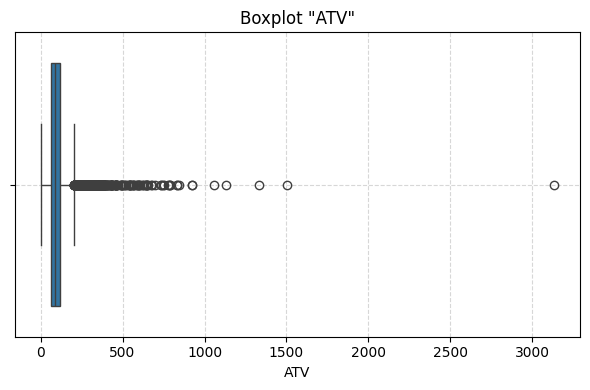

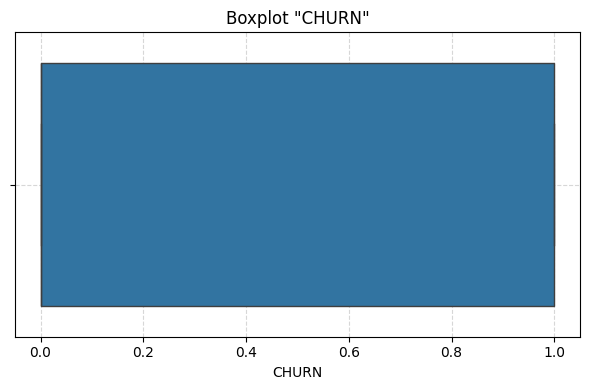

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = stylink_df_users.select_dtypes(include='number').columns

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=stylink_df_users[col].dropna())
    plt.title(f'Boxplot "{col}"')
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [53]:
import pandas as pd

# Select numeric columns
numericas = stylink_df_users.select_dtypes(include=['number']).columns

# Create list with results
outliers_info = []

# Detect outliers with IQR
for col in numericas:
    Q1 = stylink_df_users[col].quantile(0.25)
    Q3 = stylink_df_users[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter outliers
    outliers = stylink_df_users[(stylink_df_users[col] < lower_bound) | (stylink_df_users[col] > upper_bound)]
    
    # Save info
    for _, row in outliers.iterrows():
        outliers_info.append({
            'USER_ID': row['USER_ID'],
            'Columna': col,
            'Valor': row[col]
        })

# Convert dataframe to visualize
df_outliers = pd.DataFrame(outliers_info)

# Show outliers
print(df_outliers)
print("Unique User_IDs with outliers:", df_outliers['USER_ID'].nunique())
print(df_outliers['Columna'].value_counts())


       USER_ID Columna         Valor
0           73     GMV  9.004865e+04
1          166     GMV  1.734776e+06
2          178     GMV  7.446483e+05
3          211     GMV  9.229043e+04
4          243     GMV  2.432873e+05
...        ...     ...           ...
11194   281883     ATV  2.616500e+02
11195   282412     ATV  3.297100e+02
11196   283040     ATV  2.543500e+02
11197   283351     ATV  2.220000e+02
11198   283826     ATV  3.529200e+02

[11199 rows x 3 columns]
Unique User_IDs with outliers: 3343
Columna
GMV                     1437
NO_TRANSACTIONS         1381
PROVISION               1378
COMMISSION              1359
LINKS_W_TRANSACTIONS    1140
LINK_COUNT               950
ACTIVITY                 950
AVG_LINKS_PER_MONTH      828
FACTOR                   616
DIVERSITY                541
ATV                      454
RECENCY                  165
Name: count, dtype: int64


DATA PREPROCESSING: CHANGE OF VARIABLE TYPE

In [54]:
stylink_df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8296 entries, 0 to 8295
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   USER_ID                    8296 non-null   int64         
 1   REGISTER_DATE              8296 non-null   object        
 2   GMV                        8296 non-null   float64       
 3   PROVISION                  8296 non-null   float64       
 4   COMMISSION                 8296 non-null   float64       
 5   NO_TRANSACTIONS            8296 non-null   int64         
 6   LINK_COUNT                 8296 non-null   int64         
 7   FACTOR                     8296 non-null   float64       
 8   FIRST_LINK_DATE            8296 non-null   datetime64[ns]
 9   LAST_LINK_DATE             8296 non-null   datetime64[ns]
 10  LENGTH                     8296 non-null   int64         
 11  RECENCY                    8296 non-null   int64         
 12  ACTIVI

In [55]:
# Convert USER_ID to object
stylink_df_users['USER_ID'] = stylink_df_users['USER_ID'].astype('object')

# Convert REGISTER_DATE to datetime
stylink_df_users['REGISTER_DATE'] = pd.to_datetime(stylink_df_users['REGISTER_DATE'])

# Convert LINKS_W_TRANSACTIONS to integer
stylink_df_users['LINKS_W_TRANSACTIONS'] = stylink_df_users['LINKS_W_TRANSACTIONS'].astype('int64')

# Convert CHURN to boolean
stylink_df_users['CHURN'] = stylink_df_users['CHURN'].astype('bool')

# Show resulting DataFrame 
print(stylink_df_users.dtypes)

USER_ID                              object
REGISTER_DATE                datetime64[ns]
GMV                                 float64
PROVISION                           float64
COMMISSION                          float64
NO_TRANSACTIONS                       int64
LINK_COUNT                            int64
FACTOR                              float64
FIRST_LINK_DATE              datetime64[ns]
LAST_LINK_DATE               datetime64[ns]
LENGTH                                int64
RECENCY                               int64
ACTIVITY                              int64
LINKS_W_TRANSACTIONS                  int64
PERC_LINKS_W_TRANSACTIONS           float64
DIVERSITY                             int64
AVG_LINKS_PER_MONTH                 float64
ATV                                 float64
CHURN                                  bool
dtype: object


RFE - Decision Tree and Logistic Regression

In [56]:
# 1. Eliminate non predictive variables and date variables
X = stylink_df_users.drop(columns=['USER_ID', 'REGISTER_DATE', 'FIRST_LINK_DATE', 'LAST_LINK_DATE', 'CHURN'])

# 2. Convert boolean values to integers
X = X.apply(lambda col: col.astype(int) if col.dtype == 'bool' else col)

# 3. Define output variable
y = stylink_df_users['CHURN'].astype(int)

# 4. Escale variables for logistic regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
# Create logistic regression model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Apply RFE
rfe_lr = RFE(estimator=lr_model, n_features_to_select=10) 
rfe_lr.fit(X_scaled, y)

# Show chosen variables
selected_features_lr = X.columns[rfe_lr.support_]
print("Chosen variables for logistic regression:")
print(selected_features_lr)


Chosen variables for logistic regression:
Index(['GMV', 'PROVISION', 'COMMISSION', 'NO_TRANSACTIONS', 'FACTOR', 'LENGTH',
       'RECENCY', 'ACTIVITY', 'LINKS_W_TRANSACTIONS', 'DIVERSITY'],
      dtype='object')


In [58]:
# Create logistic regression model
dt_model = DecisionTreeClassifier(random_state=42)

# Apply RFE
rfe_dt = RFE(estimator=dt_model, n_features_to_select=10)
rfe_dt.fit(X, y)  # Para árboles, no es necesario escalar

# Show chosen variables
selected_features_dt = X.columns[rfe_dt.support_]
print("Chosen variables for decision tree:")
print(selected_features_dt)

Chosen variables for decision tree:
Index(['LINK_COUNT', 'FACTOR', 'LENGTH', 'RECENCY', 'ACTIVITY',
       'LINKS_W_TRANSACTIONS', 'PERC_LINKS_W_TRANSACTIONS', 'DIVERSITY',
       'AVG_LINKS_PER_MONTH', 'ATV'],
      dtype='object')


VARIABLE STANDARDIZATION 

In [59]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Numeric columns that need to be stantardised 
columnas_numericas = [
    'ACTIVITY', 'LINKS_W_TRANSACTIONS', 'PERC_LINKS_W_TRANSACTIONS',
    'DIVERSITY', 'AVG_LINKS_PER_MONTH', 'ATV', 'RECENCY', 'LENGTH', 'GMV', 'PROVISION', 
    'COMMISSION', 'NO_TRANSACTIONS', 'LINK_COUNT', 'FACTOR'
]

# 2. Eliminate all NANs
X = stylink_df_users[columnas_numericas].copy()
X = X.fillna(0)

# 3. StandrdScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Convert DataFrame to keep column names
X_scaled_df = pd.DataFrame(X_scaled, columns=columnas_numericas)

# 5. Add additional columns
X_scaled_df['USER_ID'] = stylink_df_users['USER_ID'].values
X_scaled_df['REGISTER_DATE'] = stylink_df_users['REGISTER_DATE'].values
X_scaled_df['FIRST_LINK_DATE'] = stylink_df_users['FIRST_LINK_DATE'].values
X_scaled_df['LAST_LINK_DATE'] = stylink_df_users['LAST_LINK_DATE'].values

# Convert Churn to 0 and 1
X_scaled_df['CHURN'] = stylink_df_users['CHURN'].astype(int).values

# Show results
print(X_scaled_df.head())



   ACTIVITY  LINKS_W_TRANSACTIONS  PERC_LINKS_W_TRANSACTIONS  DIVERSITY  \
0 -0.178650             -0.128116                   0.708886  -0.470208   
1 -0.038814             -0.109306                  -1.008601  -0.005863   
2 -0.038814              0.014305                   1.006751   0.806741   
3 -0.171386             -0.133491                  -1.047766  -0.586294   
4  0.462414              0.285711                   0.128605   3.592812   

   AVG_LINKS_PER_MONTH       ATV   RECENCY    LENGTH       GMV  PROVISION  \
0            -0.287071  1.967972 -0.473685  1.048143 -0.150308  -0.132284   
1             0.304705  0.085880  0.800112 -0.700981 -0.147057  -0.133658   
2            -0.118738 -0.119719 -0.730184  0.358059 -0.097018  -0.074337   
3            -0.263770 -0.487089  0.369716  0.122337 -0.151396  -0.135331   
4             0.221141 -0.010616 -0.812785  1.533252 -0.008924  -0.038942   

   COMMISSION  NO_TRANSACTIONS  LINK_COUNT    FACTOR USER_ID  \
0   -0.169122        -

FINAL DATASET (clean and preprocessed)

In [60]:
stylink_df_users_clean = X_scaled_df

In [61]:
stylink_df_users_clean.info

<bound method DataFrame.info of       ACTIVITY  LINKS_W_TRANSACTIONS  PERC_LINKS_W_TRANSACTIONS  DIVERSITY  \
0    -0.178650             -0.128116                   0.708886  -0.470208   
1    -0.038814             -0.109306                  -1.008601  -0.005863   
2    -0.038814              0.014305                   1.006751   0.806741   
3    -0.171386             -0.133491                  -1.047766  -0.586294   
4     0.462414              0.285711                   0.128605   3.592812   
...        ...                   ...                        ...        ...   
8291 -0.182282             -0.133491                  -0.249386  -0.586294   
8292 -0.176834             -0.133491                  -0.847991  -0.818467   
8293 -0.175018             -0.133491                  -0.933506  -0.586294   
8294 -0.175018             -0.133491                  -0.933506  -0.818467   
8295 -0.184098             -0.130804                   2.146113  -0.702381   

      AVG_LINKS_PER_MONTH      

In [62]:
stylink_df_users_clean.to_csv("stylink_df_users_clean.csv", index=False)

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, mean_squared_error
)
features = ['NO_TRANSACTIONS', 'FACTOR', 'LENGTH', 'ACTIVITY', 'LINKS_W_TRANSACTIONS', 'DIVERSITY']

# Define OUTPUT Variable
target = 'CHURN'

# Divide data between predictive and output variables
X = stylink_df_users_clean[features]
y = stylink_df_users_clean[target]

# Divide data in test and training subsets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create model
logreg = LogisticRegression()

# Train model
logreg.fit(X_train, y_train)

# Predictions with test subset
y_pred = logreg.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Show results
print("1. Accuracy:", accuracy)
print("2. Confusion matrix:\n", conf_matrix)
print("3. Classification report:\n", class_report)


1. Accuracy: 0.6746987951807228
2. Confusion matrix:
 [[573 289]
 [251 547]]
3. Classification report:
               precision    recall  f1-score   support

           0       0.70      0.66      0.68       862
           1       0.65      0.69      0.67       798

    accuracy                           0.67      1660
   macro avg       0.67      0.68      0.67      1660
weighted avg       0.68      0.67      0.67      1660



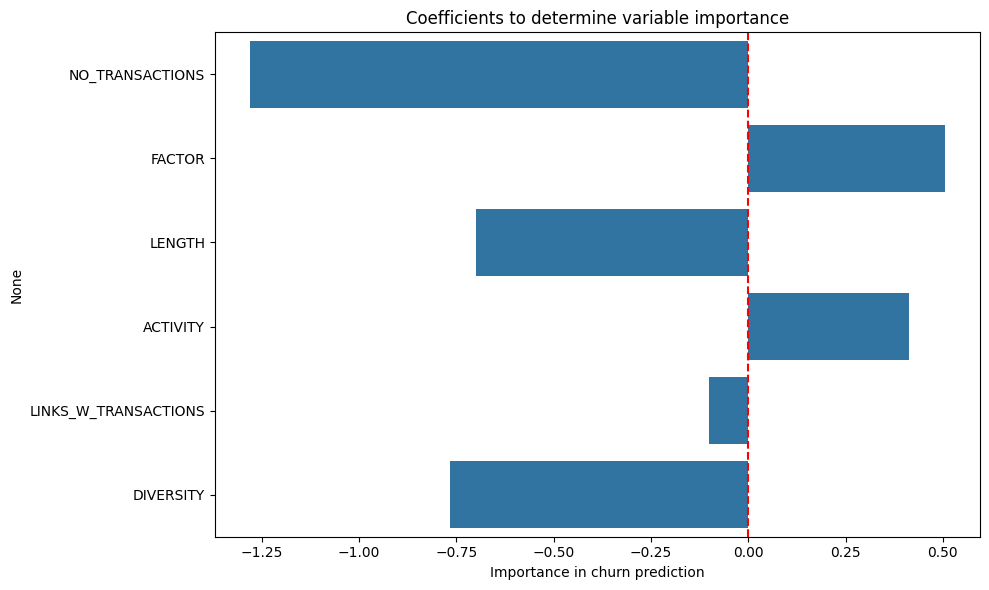

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

coefs = pd.Series(logreg.coef_[0], index=X_train.columns)
plt.figure(figsize=(10,6))
sns.barplot(x=coefs.values, y=coefs.index)
plt.title("Coefficients to determine variable importance")
plt.xlabel("Importance in churn prediction")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

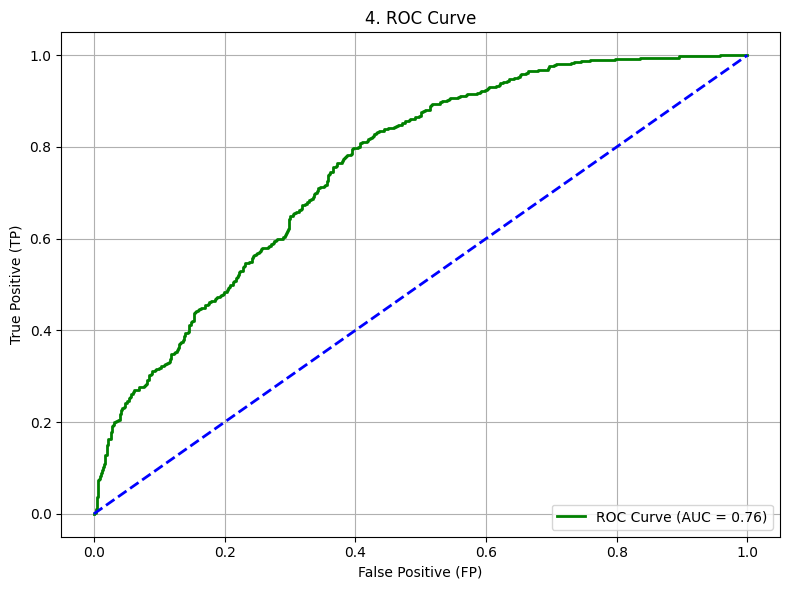

In [66]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Obtain model predictions for churn = 1
y_proba = logreg.predict_proba(X_test)[:, 1]

# 2. Calculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# 3. Show results
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive (FP)')
plt.ylabel('True Positive (TP)')
plt.title('4. ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


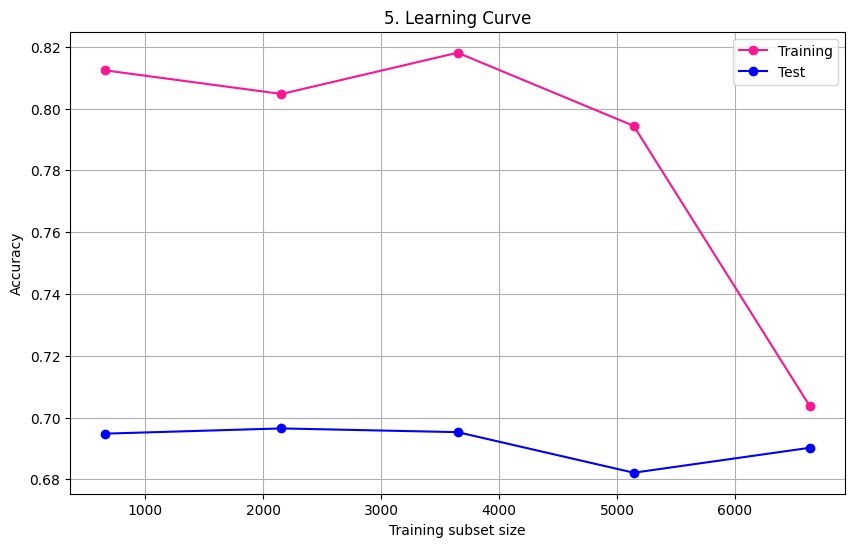

In [68]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    logreg, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='deeppink', label="Training")  # Rosa
plt.plot(train_sizes, test_scores_mean, 'o-', color='blue', label="Test")              # Azul
plt.xlabel("Training subset size")
plt.ylabel("Accuracy")
plt.title("5. Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


Best depth: 4
1. Accuracy: 0.7139
2. Confusion Matrix:
[[578 284]
 [191 607]]
3. Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.67      0.71       862
        True       0.68      0.76      0.72       798

    accuracy                           0.71      1660
   macro avg       0.72      0.72      0.71      1660
weighted avg       0.72      0.71      0.71      1660



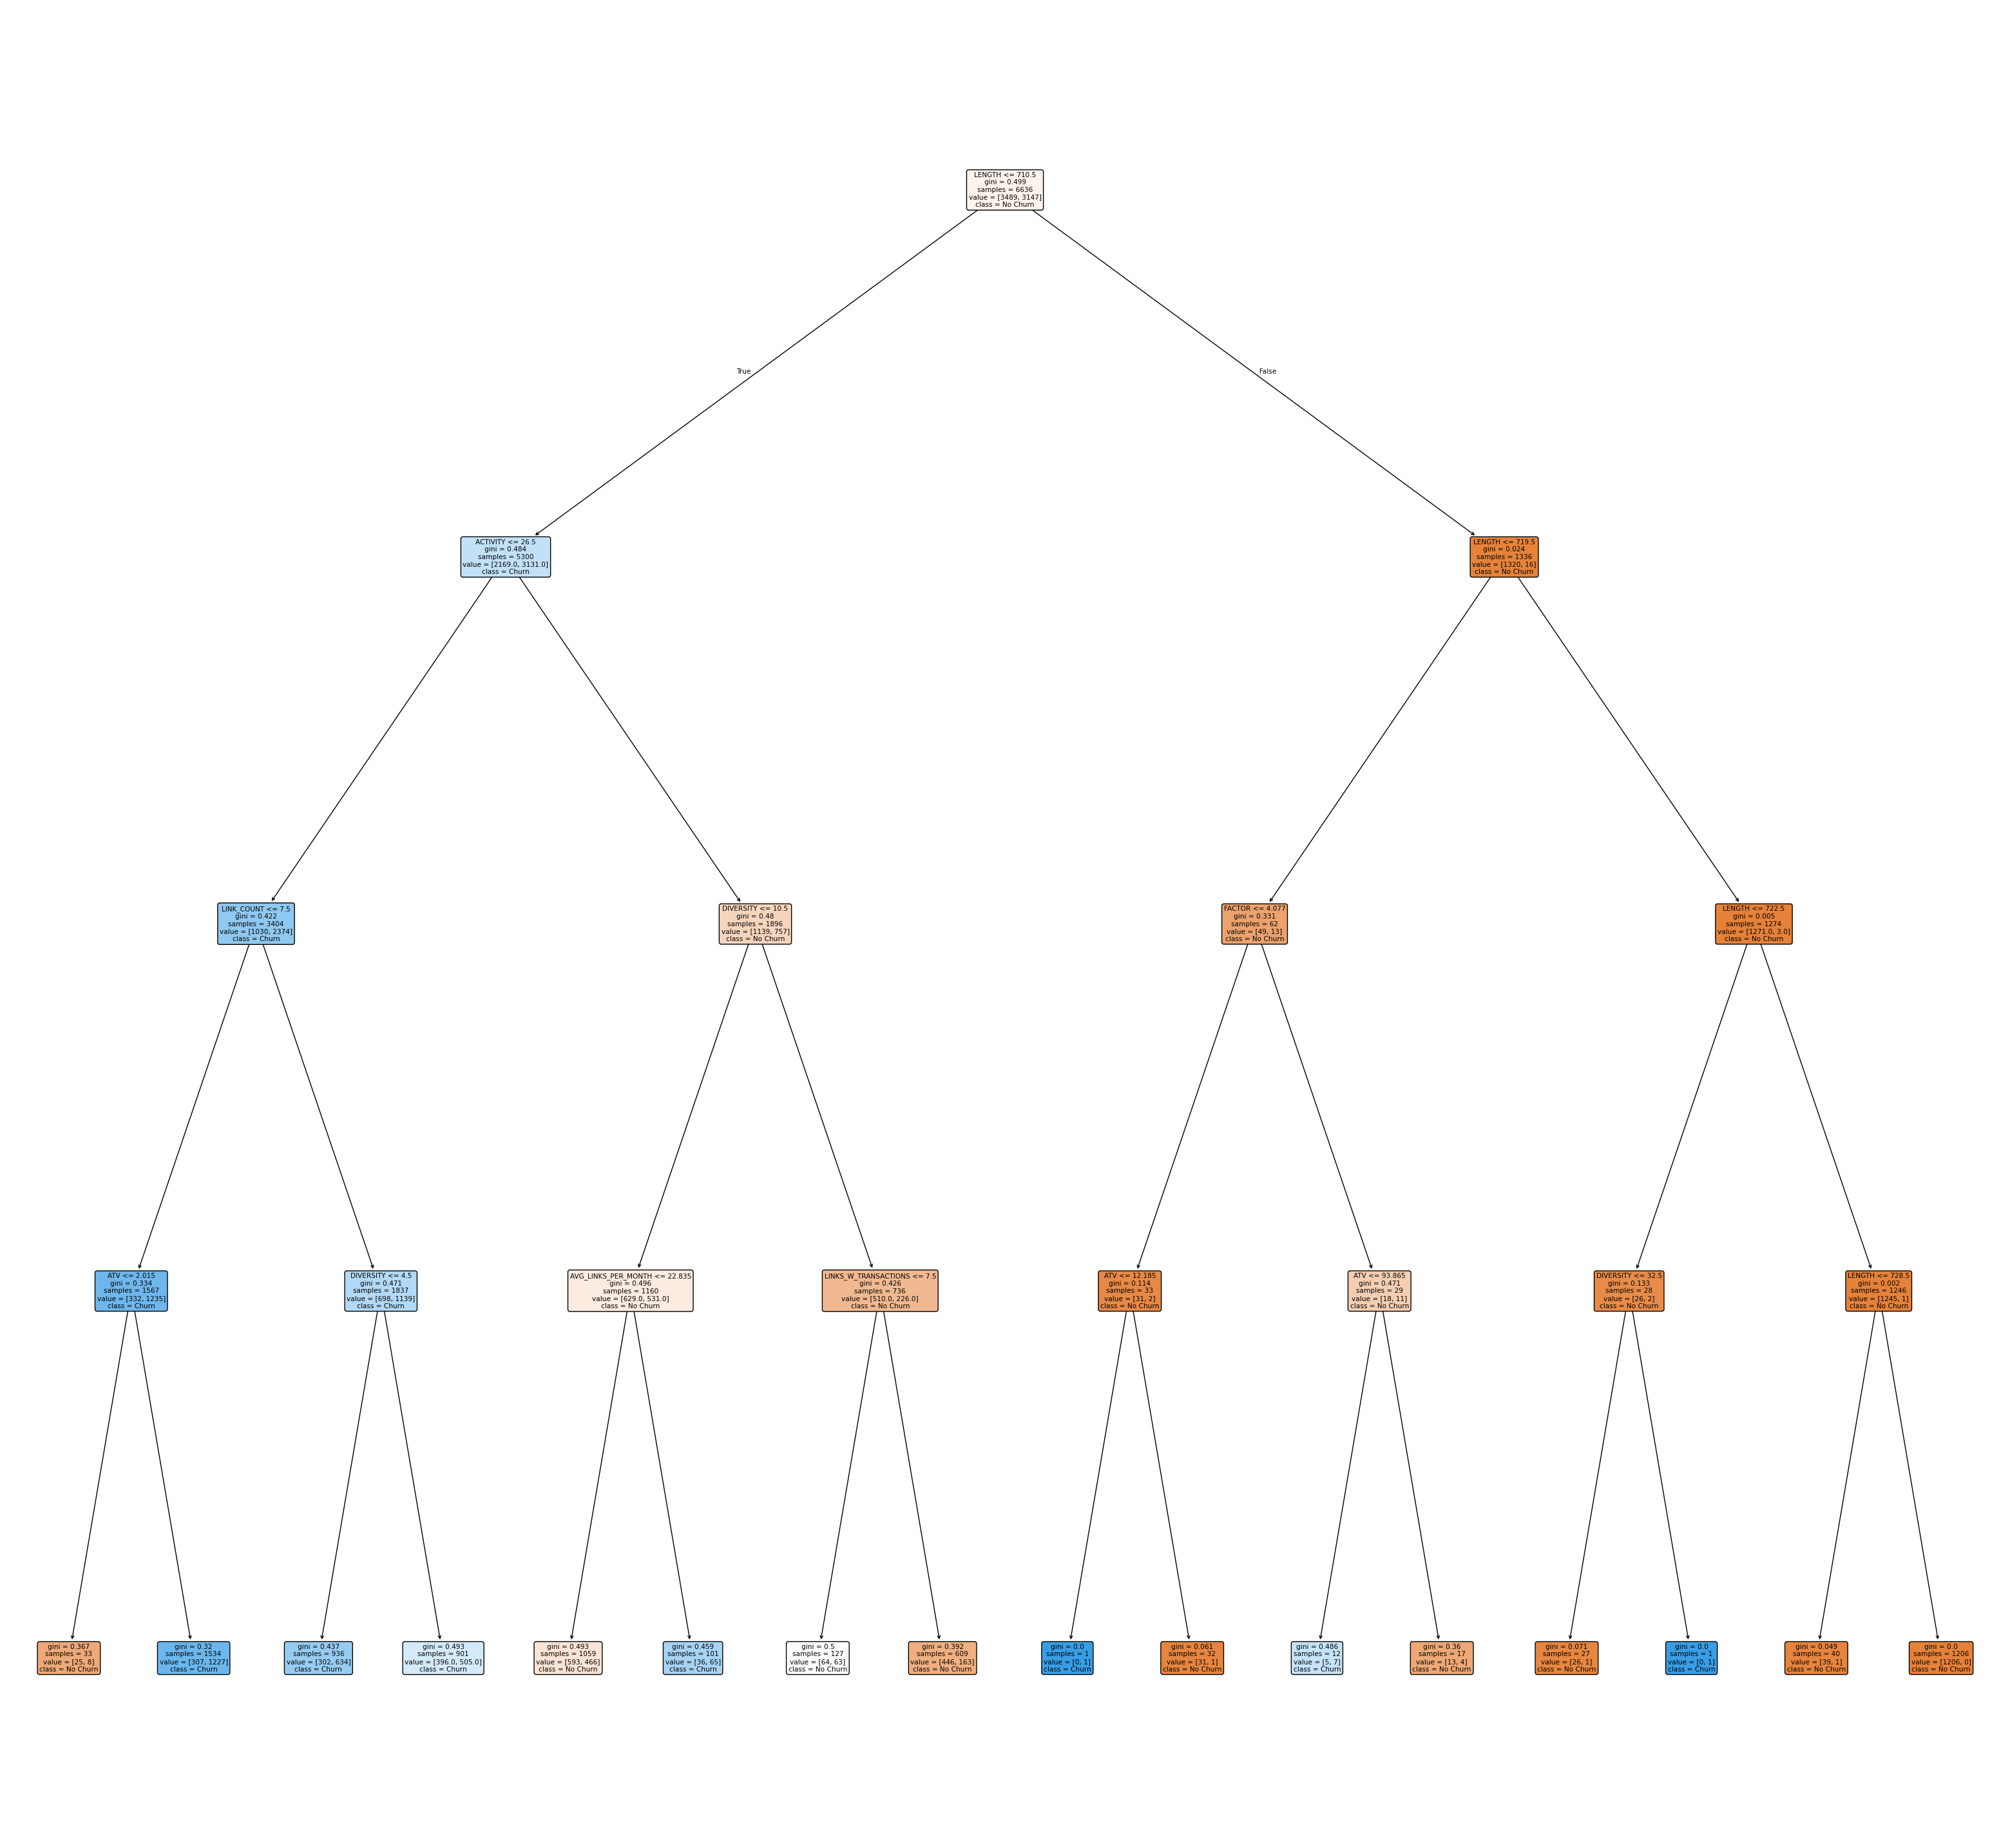

In [71]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

X = stylink_df_users[['LINK_COUNT', 'FACTOR', 'LENGTH', 'ACTIVITY',
                            'LINKS_W_TRANSACTIONS', 'DIVERSITY',
                            'AVG_LINKS_PER_MONTH', 'ATV']]
y = stylink_df_users['CHURN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = DecisionTreeClassifier(random_state=42)

# Define hyperparamets to test
param_grid = {'max_depth': list(range(1, 11))}  # depth test from 1 to 10

# Configure search with cross validation
grid_search = GridSearchCV(estimator=base_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

# Adjust model with training data 
grid_search.fit(X_train, y_train)

# Most suitable model 
best_model = grid_search.best_estimator_
print(f"Best depth: {grid_search.best_params_['max_depth']}")

# Evaluate model with test dataset 
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"1. Accuracy: {accuracy:.4f}")
print("2. Confusion Matrix:")
print(conf_matrix)
print("3. Classification Report:")
print(class_report)

# Show decision tree 
plt.figure(figsize=(40, 37))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['No Churn', 'Churn'], rounded=True)
plt.show()

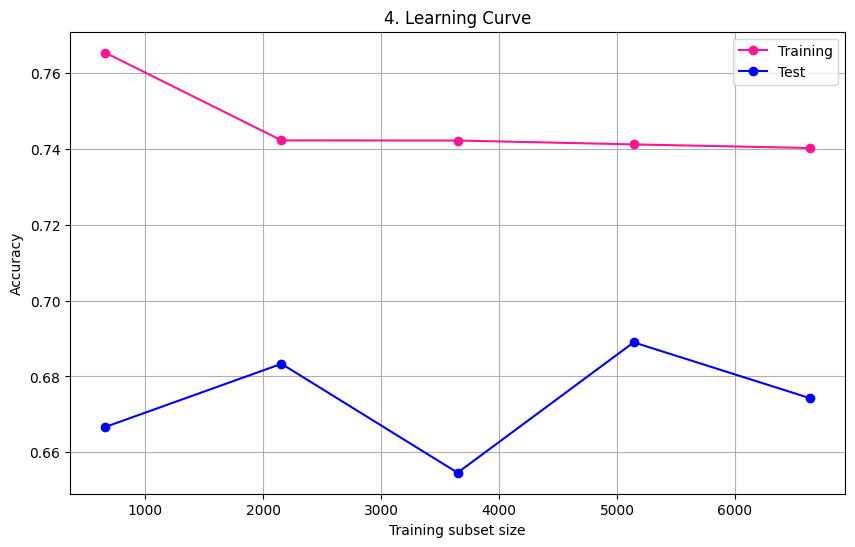

In [72]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    shuffle=True,
    random_state=42
)

# Calculate average
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Visualize curve 
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='deeppink', label="Training")  # Rosa
plt.plot(train_sizes, test_scores_mean, 'o-', color='blue', label="Test")              # Azul
plt.xlabel("Training subset size")
plt.ylabel("Accuracy")
plt.title("4. Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


FIND OUT WHICH ARE CHURN USERS 

In [73]:
y_pred = best_model.predict(X_test)
# Aggregate USER_ID if it wasnt on X 
X = stylink_df_users[features + ['USER_ID']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
# Add predictions to X_Test
X_test = X_test.copy()
X_test['PRED_CHURN'] = y_pred

# Filter only users that model has identified as churn 
usuarios_churn = X_test[X_test['PRED_CHURN'] == 1]

# Show only User_ID
print(usuarios_churn['USER_ID'])

3994    157196
8175    279944
2280     94745
8237    281790
2925    125323
         ...  
620      15956
1544     71170
4745    168965
7897    271124
6992    224746
Name: USER_ID, Length: 891, dtype: object


In [74]:
usuarios_churn['USER_ID'].to_csv("usuarios_predichos_churn.csv", index=False)

FIND OUT CHURN PROBABILITY 

In [75]:
features = ['LINK_COUNT', 'FACTOR', 'LENGTH', 'ACTIVITY',
                            'LINKS_W_TRANSACTIONS', 'DIVERSITY',
                            'AVG_LINKS_PER_MONTH', 'ATV']

X = stylink_df_users[features]
y = stylink_df_users['CHURN']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [76]:
# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Add to X_test
X_test = X_test.copy()
X_test['USER_ID'] = stylink_df_users_clean.loc[X_test.index, 'USER_ID'] 
X_test['PRED_CHURN'] = y_pred
X_test['CHURN_PROB'] = y_proba[:, 1]


In [77]:
usuarios_churn = X_test[X_test['PRED_CHURN'] == 1]
print(usuarios_churn[['USER_ID', 'CHURN_PROB']].sort_values(by='CHURN_PROB', ascending=False))


     USER_ID  CHURN_PROB
4661  167837    1.000000
2523  105469    0.799870
7418  250098    0.799870
3290  141073    0.799870
1053   45522    0.799870
...      ...         ...
6008  190721    0.560488
7873  267884    0.560488
3254  139608    0.560488
2944  126297    0.560488
6992  224746    0.560488

[891 rows x 2 columns]


In [78]:
usuarios_churn[['USER_ID', 'CHURN_PROB']].to_csv("usuarios_predichos_churn_prob.csv", index=False)

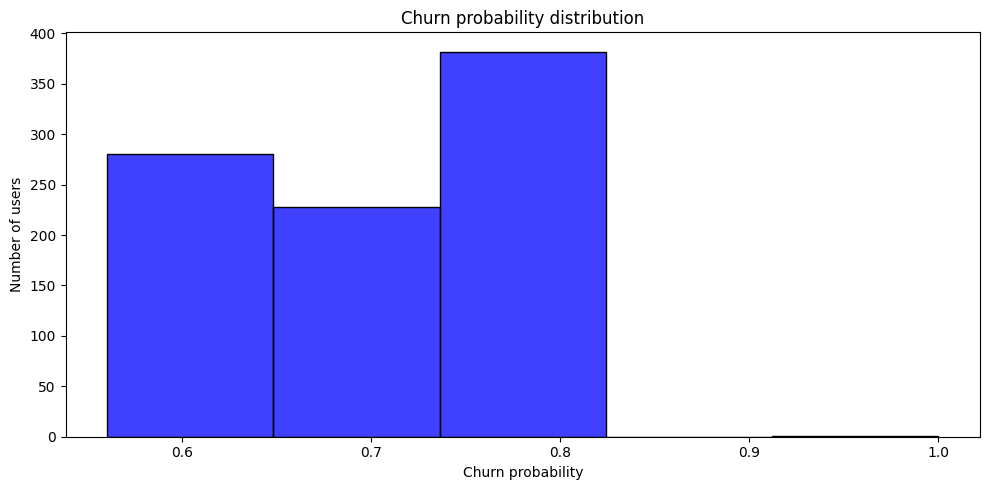

In [79]:
plt.figure(figsize=(10, 5))
sns.histplot(usuarios_churn['CHURN_PROB'], bins=5, color='blue')
plt.title('Churn probability distribution')
plt.xlabel('Churn probability')
plt.ylabel('Number of users')
plt.tight_layout()
plt.show()

